I'm glad to share my plan. This is based on the landmark notebook by Chris [Here](https://www.kaggle.com/code/cdeotte/xgboost-baseline-0-676). Thanks to him and all the participants who share their ideas.
My inference part is [Here](https://www.kaggle.com/code/takanashihumbert/magic-bingo-inference-part-lb-0-687)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import pickle
import polars as pl
from sklearn.model_selection import KFold, GroupKFold, train_test_split
from xgboost import XGBClassifier
# from catboost import CatBoostClassifier, Pool
from sklearn.metrics import f1_score
from tqdm.notebook import tqdm
from collections import defaultdict
import warnings
from itertools import combinations

warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

In [4]:
# targets = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train_labels.csv')

# ----------------Locally load data
targets = pd.read_csv('./train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]))
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]))
print(targets.shape)

(424116, 4)


In [5]:
train_dtypes = {"session_id": pl.Int64,"elapsed_time": pl.Int64,"event_name": pl.Categorical,
                "name": pl.Categorical,"level": pl.Int8,"page": pl.Float32,
                "room_coor_x": pl.Float32,"room_coor_y": pl.Float32,"screen_coor_x": pl.Float32,
                "screen_coor_y": pl.Float32,"hover_duration": pl.Float32,"text": pl.Utf8,
                "fqid": pl.Utf8,"room_fqid": pl.Categorical,"text_fqid": pl.Utf8,
                "fullscreen": pl.Int8,"hq": pl.Int8,"music": pl.Int8,"level_group": pl.Categorical
               }

In [6]:
columns = [
    pl.col("page").cast(pl.Float32),
    (
        (pl.col("elapsed_time") - pl.col("elapsed_time").shift(1)) # time used for each action
         .fill_null(0)
         .clip(0, 1e9)
         .over(["session_id", "level_group"])
         .alias("elapsed_time_diff")
    ),
    (
        (pl.col("screen_coor_x") - pl.col("screen_coor_x").shift(1)) # location x changed for click 
         .abs()
         .over(["session_id", "level_group"])
    ),
    (
        (pl.col("screen_coor_y") - pl.col("screen_coor_y").shift(1)) # location y changed for click 
         .abs()
         .over(["session_id", "level_group"])
    ),
    pl.col("fqid").fill_null("fqid_None"),
    pl.col("text_fqid").fill_null("text_fqid_None")
]

In [7]:
%%time

# we prepare the dataset for the training by level :
"""df = (pl.read_csv("/kaggle/input/predict-student-performance-from-game-play/train.csv", dtypes=train_dtypes)
      .drop(["fullscreen", "hq", "music"])
      .with_columns(columns))"""
#df = reduce_mem_usage_pl(df)

# ----------------Locally load data
df = (pl.read_csv("./train.csv", dtypes=train_dtypes)
      .drop(["fullscreen", "hq", "music"])
      .with_columns(columns))

print(f'df loaded with shape: {df.shape}')

df loaded with shape: (26296946, 18)
CPU times: user 29.6 s, sys: 11.2 s, total: 40.7 s
Wall time: 7.99 s


In [8]:
df1 = df.filter(pl.col("level_group")=='0-4')
df2 = df.filter(pl.col("level_group")=='5-12')
df3 = df.filter(pl.col("level_group")=='13-22')

print(f'df1 loaded with shape: {df1.shape}')
print(f'df2 loaded with shape: {df2.shape}')
print(f'df3 loaded with shape: {df3.shape}')

del df
gc.collect()

df1 loaded with shape: (3981005, 18)
df2 loaded with shape: (8844238, 18)
df3 loaded with shape: (13471703, 18)


77

In [9]:
CATS = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']

event_name_feature = ['cutscene_click', 'person_click', 'navigate_click',
       'observation_click', 'notification_click', 'object_click',
       'object_hover', 'map_hover', 'map_click', 'checkpoint',
       'notebook_click']

name_feature = ['basic', 'undefined', 'close', 'open', 'prev', 'next']

NUMS = [ 
    'page', 
    'room_coor_x', 
    'room_coor_y', 
    'screen_coor_x', 
    'screen_coor_y', 
    'hover_duration', 
    'elapsed_time_diff'
]


# ----------------From another Notebook https://www.kaggle.com/code/xiaosufrankhu/lgbm-train-infer-with-cpu
DIALOGS = ['that', 'this', 'it', 'you','find','found','Found','notebook','Wells','wells','help','need', 'Oh','Ooh','Jo', 'flag', 'can','and','is','the','to']
# DIALOGS = ['Gramps','myself', 'national movement', 'Wisconsin Wonders','Earth Day', '1916', 'cleaning', 'cleaner', 'slip', 'jersey', 'Theodora Youmans', 'suffragist', 'that', 'this', 'it', 'you','find','found','Found','notebook','Wells','wells','help','need', 'Oh','Ooh','Jo', 'flag', 'can','and','is','the','to']

fqid_lists = ['worker', 'archivist', 'gramps', 'wells', 'toentry', 'confrontation', 'crane_ranger', 'groupconvo', 'flag_girl', 'tomap', 'tostacks', 'tobasement', 'archivist_glasses', 'boss', 'journals', 'seescratches', 'groupconvo_flag', 'cs', 'teddy', 'expert', 'businesscards', 'ch3start', 'tunic.historicalsociety', 'tofrontdesk', 'savedteddy', 'plaque', 'glasses', 'tunic.drycleaner', 'reader_flag', 'tunic.library', 'tracks', 'tunic.capitol_2', 'trigger_scarf', 'reader', 'directory', 'tunic.capitol_1', 'journals.pic_0.next', 'unlockdoor', 'tunic', 'what_happened', 'tunic.kohlcenter', 'tunic.humanecology', 'colorbook', 'logbook', 'businesscards.card_0.next', 'journals.hub.topics', 'logbook.page.bingo', 'journals.pic_1.next', 'journals_flag', 'reader.paper0.next', 'tracks.hub.deer', 'reader_flag.paper0.next', 'trigger_coffee', 'wellsbadge', 'journals.pic_2.next', 'tomicrofiche', 'journals_flag.pic_0.bingo', 'plaque.face.date', 'notebook', 'tocloset_dirty', 'businesscards.card_bingo.bingo', 'businesscards.card_1.next', 'tunic.wildlife', 'tunic.hub.slip', 'tocage', 'journals.pic_2.bingo', 'tocollectionflag', 'tocollection', 'chap4_finale_c', 'chap2_finale_c', 'lockeddoor', 'journals_flag.hub.topics', 'tunic.capitol_0', 'reader_flag.paper2.bingo', 'photo', 'tunic.flaghouse', 'reader.paper1.next', 'directory.closeup.archivist', 'intro', 'businesscards.card_bingo.next', 'reader.paper2.bingo', 'retirement_letter', 'remove_cup', 'journals_flag.pic_0.next', 'magnify', 'coffee', 'key', 'togrampa', 'reader_flag.paper1.next', 'janitor', 'tohallway', 'chap1_finale', 'report', 'outtolunch', 'journals_flag.hub.topics_old', 'journals_flag.pic_1.next', 'reader.paper2.next', 'chap1_finale_c', 'reader_flag.paper2.next', 'door_block_talk', 'journals_flag.pic_1.bingo', 'journals_flag.pic_2.next', 'journals_flag.pic_2.bingo', 'block_magnify', 'reader.paper0.prev', 'block', 'reader_flag.paper0.prev', 'block_0', 'door_block_clean', 'reader.paper2.prev', 'reader.paper1.prev', 'doorblock', 'tocloset', 'reader_flag.paper2.prev', 'reader_flag.paper1.prev', 'block_tomap2', 'journals_flag.pic_0_old.next', 'journals_flag.pic_1_old.next', 'block_tocollection', 'block_nelson', 'journals_flag.pic_2_old.next', 'block_tomap1', 'block_badge', 'need_glasses', 'block_badge_2', 'fox', 'block_1']
text_lists = ['tunic.historicalsociety.cage.confrontation', 'tunic.wildlife.center.crane_ranger.crane', 'tunic.historicalsociety.frontdesk.archivist.newspaper', 'tunic.historicalsociety.entry.groupconvo', 'tunic.wildlife.center.wells.nodeer', 'tunic.historicalsociety.frontdesk.archivist.have_glass', 'tunic.drycleaner.frontdesk.worker.hub', 'tunic.historicalsociety.closet_dirty.gramps.news', 'tunic.humanecology.frontdesk.worker.intro', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation', 'tunic.historicalsociety.basement.seescratches', 'tunic.historicalsociety.collection.cs', 'tunic.flaghouse.entry.flag_girl.hello', 'tunic.historicalsociety.collection.gramps.found', 'tunic.historicalsociety.basement.ch3start', 'tunic.historicalsociety.entry.groupconvo_flag', 'tunic.library.frontdesk.worker.hello', 'tunic.library.frontdesk.worker.wells', 'tunic.historicalsociety.collection_flag.gramps.flag', 'tunic.historicalsociety.basement.savedteddy', 'tunic.library.frontdesk.worker.nelson', 'tunic.wildlife.center.expert.removed_cup', 'tunic.library.frontdesk.worker.flag', 'tunic.historicalsociety.frontdesk.archivist.hello', 'tunic.historicalsociety.closet.gramps.intro_0_cs_0', 'tunic.historicalsociety.entry.boss.flag', 'tunic.flaghouse.entry.flag_girl.symbol', 'tunic.historicalsociety.closet_dirty.trigger_scarf', 'tunic.drycleaner.frontdesk.worker.done', 'tunic.historicalsociety.closet_dirty.what_happened', 'tunic.wildlife.center.wells.animals', 'tunic.historicalsociety.closet.teddy.intro_0_cs_0', 'tunic.historicalsociety.cage.glasses.afterteddy', 'tunic.historicalsociety.cage.teddy.trapped', 'tunic.historicalsociety.cage.unlockdoor', 'tunic.historicalsociety.stacks.journals.pic_2.bingo', 'tunic.historicalsociety.entry.wells.flag', 'tunic.humanecology.frontdesk.worker.badger', 'tunic.historicalsociety.stacks.journals_flag.pic_0.bingo', 'tunic.historicalsociety.closet.intro', 'tunic.historicalsociety.closet.retirement_letter.hub', 'tunic.historicalsociety.entry.directory.closeup.archivist', 'tunic.historicalsociety.collection.tunic.slip', 'tunic.kohlcenter.halloffame.plaque.face.date', 'tunic.historicalsociety.closet_dirty.trigger_coffee', 'tunic.drycleaner.frontdesk.logbook.page.bingo', 'tunic.library.microfiche.reader.paper2.bingo', 'tunic.kohlcenter.halloffame.togrampa', 'tunic.capitol_2.hall.boss.haveyougotit', 'tunic.wildlife.center.wells.nodeer_recap', 'tunic.historicalsociety.cage.glasses.beforeteddy', 'tunic.historicalsociety.closet_dirty.gramps.helpclean', 'tunic.wildlife.center.expert.recap', 'tunic.historicalsociety.frontdesk.archivist.have_glass_recap', 'tunic.historicalsociety.stacks.journals_flag.pic_1.bingo', 'tunic.historicalsociety.cage.lockeddoor', 'tunic.historicalsociety.stacks.journals_flag.pic_2.bingo', 'tunic.historicalsociety.collection.gramps.lost', 'tunic.historicalsociety.closet.notebook', 'tunic.historicalsociety.frontdesk.magnify', 'tunic.humanecology.frontdesk.businesscards.card_bingo.bingo', 'tunic.wildlife.center.remove_cup', 'tunic.library.frontdesk.wellsbadge.hub', 'tunic.wildlife.center.tracks.hub.deer', 'tunic.historicalsociety.frontdesk.key', 'tunic.library.microfiche.reader_flag.paper2.bingo', 'tunic.flaghouse.entry.colorbook', 'tunic.wildlife.center.coffee', 'tunic.capitol_1.hall.boss.haveyougotit', 'tunic.historicalsociety.basement.janitor', 'tunic.historicalsociety.collection_flag.gramps.recap', 'tunic.wildlife.center.wells.animals2', 'tunic.flaghouse.entry.flag_girl.symbol_recap', 'tunic.historicalsociety.closet_dirty.photo', 'tunic.historicalsociety.stacks.outtolunch', 'tunic.library.frontdesk.worker.wells_recap', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap', 'tunic.capitol_0.hall.boss.talktogramps', 'tunic.historicalsociety.closet.photo', 'tunic.historicalsociety.collection.tunic', 'tunic.historicalsociety.closet.teddy.intro_0_cs_5', 'tunic.historicalsociety.closet_dirty.gramps.archivist', 'tunic.historicalsociety.closet_dirty.door_block_talk', 'tunic.historicalsociety.entry.boss.flag_recap', 'tunic.historicalsociety.frontdesk.archivist.need_glass_0', 'tunic.historicalsociety.entry.wells.talktogramps', 'tunic.historicalsociety.frontdesk.block_magnify', 'tunic.historicalsociety.frontdesk.archivist.foundtheodora', 'tunic.historicalsociety.closet_dirty.gramps.nothing', 'tunic.historicalsociety.closet_dirty.door_block_clean', 'tunic.capitol_1.hall.boss.writeitup', 'tunic.library.frontdesk.worker.nelson_recap', 'tunic.library.frontdesk.worker.hello_short', 'tunic.historicalsociety.stacks.block', 'tunic.historicalsociety.frontdesk.archivist.need_glass_1', 'tunic.historicalsociety.entry.boss.talktogramps', 'tunic.historicalsociety.frontdesk.archivist.newspaper_recap', 'tunic.historicalsociety.entry.wells.flag_recap', 'tunic.drycleaner.frontdesk.worker.done2', 'tunic.library.frontdesk.worker.flag_recap', 'tunic.humanecology.frontdesk.block_0', 'tunic.library.frontdesk.worker.preflag', 'tunic.historicalsociety.basement.gramps.seeyalater', 'tunic.flaghouse.entry.flag_girl.hello_recap', 'tunic.historicalsociety.closet.doorblock', 'tunic.drycleaner.frontdesk.worker.takealook', 'tunic.historicalsociety.basement.gramps.whatdo', 'tunic.library.frontdesk.worker.droppedbadge', 'tunic.historicalsociety.entry.block_tomap2', 'tunic.library.frontdesk.block_nelson', 'tunic.library.microfiche.block_0', 'tunic.historicalsociety.entry.block_tocollection', 'tunic.historicalsociety.entry.block_tomap1', 'tunic.historicalsociety.collection.gramps.look_0', 'tunic.library.frontdesk.block_badge', 'tunic.historicalsociety.cage.need_glasses', 'tunic.library.frontdesk.block_badge_2', 'tunic.kohlcenter.halloffame.block_0', 'tunic.capitol_0.hall.chap1_finale_c', 'tunic.capitol_1.hall.chap2_finale_c', 'tunic.capitol_2.hall.chap4_finale_c', 'tunic.wildlife.center.fox.concern', 'tunic.drycleaner.frontdesk.block_0', 'tunic.historicalsociety.entry.gramps.hub', 'tunic.humanecology.frontdesk.block_1', 'tunic.drycleaner.frontdesk.block_1']
room_lists = ['tunic.historicalsociety.entry', 'tunic.wildlife.center', 'tunic.historicalsociety.cage', 'tunic.library.frontdesk', 'tunic.historicalsociety.frontdesk', 'tunic.historicalsociety.stacks', 'tunic.historicalsociety.closet_dirty', 'tunic.humanecology.frontdesk', 'tunic.historicalsociety.basement', 'tunic.kohlcenter.halloffame', 'tunic.library.microfiche', 'tunic.drycleaner.frontdesk', 'tunic.historicalsociety.collection', 'tunic.historicalsociety.closet', 'tunic.flaghouse.entry', 'tunic.historicalsociety.collection_flag', 'tunic.capitol_1.hall', 'tunic.capitol_0.hall', 'tunic.capitol_2.hall']
LEVELS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
level_groups = ["0-4", "5-12", "13-22"]

Here are some useful features:
* event numbers for each sessions
* average, minimum and maximum time consumed for each 'event_name' and 'name'
* features about 'bingo'(when users successfully click the correct place and finish the phased games), which can be translated as comprehension and deductive ability.

In [10]:
def feature_engineer(x, grp, use_extra, feature_suffix):
        
    aggs = [
        pl.col("index").count().alias(f"session_number_{feature_suffix}"),
        *[pl.col(c).drop_nulls().n_unique().alias(f"{c}_unique_{feature_suffix}") for c in CATS],
        
        *[pl.col(c).mean().alias(f"{c}_mean_{feature_suffix}") for c in NUMS],
        *[pl.col(c).median().alias(f"{c}_median_{feature_suffix}") for c in NUMS],
        *[pl.col(c).std().alias(f"{c}_std_{feature_suffix}") for c in NUMS],
        *[pl.col(c).quantile(.25).alias(f"{c}_q25_{feature_suffix}") for c in NUMS],
        *[pl.col(c).quantile(.75).alias(f"{c}_q75_{feature_suffix}") for c in NUMS],

        *[pl.col('index').filter(pl.col('text').str.contains(c)).count().alias(f'word_{c}') for c in DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).mean().alias(f'word_mean_{c}') for c in DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).std().alias(f'word_std_{c}') for c in DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).sum().alias(f'word_sum_{c}') for c in DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).median().alias(f'word_median_{c}') for c in DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).quantile(.25).alias(f'word_q25_{c}') for c in DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).quantile(.75).alias(f'word_q75_{c}') for c in DIALOGS],

        #*[pl.col("event_name").filter(pl.col("event_name") == c).count().alias(f"{c}_event_name_counts{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name")==c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name")==c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name")==c).median().alias(f"{c}_ET_median_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name")==c).quantile(.25).alias(f"{c}_ET_q25_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name")==c).quantile(.75).alias(f"{c}_ET_q75_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name")==c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in event_name_feature],

        #*[pl.col("name").filter(pl.col("name") == c).count().alias(f"{c}_name_counts{feature_suffix}") for c in name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name")==c).median().alias(f"{c}_ET_median_{feature_suffix}") for c in name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name")==c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name")==c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name")==c).quantile(.25).alias(f"{c}_ET_q25_{feature_suffix}") for c in name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name")==c).quantile(.75).alias(f"{c}_ET_q75_{feature_suffix}") for c in name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name")==c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in name_feature],
        
        *[pl.col("level").filter(pl.col("level") == c).count().alias(f"{c}_LEVEL_count{feature_suffix}") for c in LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).median().alias(f"{c}_ET_median_{feature_suffix}") for c in LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).quantile(.25).alias(f"{c}_ET_q25_{feature_suffix}") for c in LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).quantile(.75).alias(f"{c}_ET_q75_{feature_suffix}") for c in LEVELS],
        
        *[pl.col("text_fqid").filter(pl.col("text_fqid") == c).count().alias(f"{c}_text_fqid_counts{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).median().alias(f"{c}_ET_median_{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).quantile(.25).alias(f"{c}_ET_q25_{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).quantile(.75).alias(f"{c}_ET_q75_{feature_suffix}") for c in text_lists],
        
        *[pl.col("room_fqid").filter(pl.col("room_fqid") == c).count().alias(f"{c}_room_fqid_counts{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).median().alias(f"{c}_ET_median_{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).quantile(.25).alias(f"{c}_ET_q25_{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).quantile(.75).alias(f"{c}_ET_q75_{feature_suffix}") for c in room_lists],
        
        *[pl.col("fqid").filter(pl.col("fqid") == c).count().alias(f"{c}_fqid_counts{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).median().alias(f"{c}_ET_median_{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).quantile(.25).alias(f"{c}_ET_q25_{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).quantile(.75).alias(f"{c}_ET_q75_{feature_suffix}") for c in fqid_lists],
    ]
    
    df = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
    
    if use_extra:
        if grp=='5-12':
            aggs = [
                pl.col("elapsed_time").filter((pl.col("text")=="Here's the log book.")|(pl.col("fqid")=='logbook.page.bingo')).apply(lambda s: s.quantile(.75)-s.quantile(.25)).alias("logbook_bingo_duration"),
                pl.col("index").filter((pl.col("text")=="Here's the log book.")|(pl.col("fqid")=='logbook.page.bingo')).apply(lambda s: s.max()-s.min()).alias("logbook_bingo_indexCount"),
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader'))|(pl.col("fqid")=="reader.paper2.bingo")).apply(lambda s: s.quantile(.75)-s.quantile(.25)).alias("reader_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader'))|(pl.col("fqid")=="reader.paper2.bingo")).apply(lambda s: s.max()-s.min()).alias("reader_bingo_indexCount"),
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals'))|(pl.col("fqid")=="journals.pic_2.bingo")).apply(lambda s: s.quantile(.75)-s.quantile(.25)).alias("journals_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals'))|(pl.col("fqid")=="journals.pic_2.bingo")).apply(lambda s: s.max()-s.min()).alias("journals_bingo_indexCount"),
            ]
            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            df = df.join(tmp, on="session_id", how='left')

        if grp=='13-22':
            aggs = [
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader_flag'))|(pl.col("fqid")=="tunic.library.microfiche.reader_flag.paper2.bingo")).apply(lambda s: s.quantile(.75)-s.quantile(.25) if s.len()>0 else 0).alias("reader_flag_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader_flag'))|(pl.col("fqid")=="tunic.library.microfiche.reader_flag.paper2.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("reader_flag_indexCount"),
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals_flag'))|(pl.col("fqid")=="journals_flag.pic_0.bingo")).apply(lambda s: s.quantile(.75)-s.quantile(.25) if s.len()>0 else 0).alias("journalsFlag_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals_flag'))|(pl.col("fqid")=="journals_flag.pic_0.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("journalsFlag_bingo_indexCount")
            ]
            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            df = df.join(tmp, on="session_id", how='left')
        
    return df.to_pandas()

In [11]:
%%time
df1 = feature_engineer(df1, grp='0-4', use_extra=True, feature_suffix='')
print(f'df1 done with shape: {df1.shape}')
df2 = feature_engineer(df2, grp='5-12', use_extra=True, feature_suffix='')
print(f'df2 done with shape: {df2.shape}')
df3 = feature_engineer(df3, grp='13-22', use_extra=True, feature_suffix='')
print(f'df3 done with shape: {df3.shape}')

df1 done with shape: (23562, 2349)
df2 done with shape: (23562, 2355)
df3 done with shape: (23562, 2353)
CPU times: user 5min 48s, sys: 7.43 s, total: 5min 55s
Wall time: 1min 2s


Remove some redundant features

In [12]:
null1 = df1.isnull().sum().sort_values(ascending=False) / len(df1)
null2 = df2.isnull().sum().sort_values(ascending=False) / len(df1)
null3 = df3.isnull().sum().sort_values(ascending=False) / len(df1)

drop1 = list(null1[null1>0.9].index)
drop2 = list(null2[null2>0.9].index)
drop3 = list(null3[null3>0.9].index)
print(len(drop1), len(drop2), len(drop3))

for col in tqdm(df1.columns):
    if df1[col].nunique()==1:
        print(col)
        drop1.append(col)
print("*********df1 DONE*********")
for col in tqdm(df2.columns):
    if df2[col].nunique()==1:
        print(col)
        drop2.append(col)
print("*********df2 DONE*********")
for col in tqdm(df3.columns):
    if df3[col].nunique()==1:
        print(col)
        drop3.append(col)
print("*********df3 DONE*********")

1428 1098 948


  0%|          | 0/2349 [00:00<?, ?it/s]

word_found
word_wells
word_Oh
word_flag
5_LEVEL_count
6_LEVEL_count
7_LEVEL_count
8_LEVEL_count
9_LEVEL_count
10_LEVEL_count
11_LEVEL_count
12_LEVEL_count
13_LEVEL_count
14_LEVEL_count
15_LEVEL_count
16_LEVEL_count
17_LEVEL_count
18_LEVEL_count
19_LEVEL_count
20_LEVEL_count
21_LEVEL_count
22_LEVEL_count
tunic.historicalsociety.cage.confrontation_text_fqid_counts
tunic.wildlife.center.crane_ranger.crane_text_fqid_counts
tunic.historicalsociety.frontdesk.archivist.newspaper_text_fqid_counts
tunic.wildlife.center.wells.nodeer_text_fqid_counts
tunic.historicalsociety.frontdesk.archivist.have_glass_text_fqid_counts
tunic.drycleaner.frontdesk.worker.hub_text_fqid_counts
tunic.historicalsociety.closet_dirty.gramps.news_text_fqid_counts
tunic.humanecology.frontdesk.worker.intro_text_fqid_counts
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_text_fqid_counts
tunic.historicalsociety.basement.seescratches_text_fqid_counts
tunic.flaghouse.entry.flag_girl.hello_text_fqid_counts
t

  0%|          | 0/2355 [00:00<?, ?it/s]

word_Found
word_notebook
word_wells
word_flag
1_LEVEL_count
2_LEVEL_count
3_LEVEL_count
4_LEVEL_count
13_LEVEL_count
14_LEVEL_count
15_LEVEL_count
16_LEVEL_count
17_LEVEL_count
18_LEVEL_count
19_LEVEL_count
20_LEVEL_count
21_LEVEL_count
22_LEVEL_count
tunic.historicalsociety.cage.confrontation_text_fqid_counts
tunic.wildlife.center.crane_ranger.crane_text_fqid_counts
tunic.historicalsociety.entry.groupconvo_text_fqid_counts
tunic.wildlife.center.wells.nodeer_text_fqid_counts
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_text_fqid_counts
tunic.historicalsociety.basement.seescratches_text_fqid_counts
tunic.historicalsociety.collection.cs_text_fqid_counts
tunic.flaghouse.entry.flag_girl.hello_text_fqid_counts
tunic.historicalsociety.collection.gramps.found_text_fqid_counts
tunic.historicalsociety.basement.ch3start_text_fqid_counts
tunic.historicalsociety.entry.groupconvo_flag_text_fqid_counts
tunic.historicalsociety.collection_flag.gramps.flag_text_fqid_counts
tunic.hi

  0%|          | 0/2353 [00:00<?, ?it/s]

word_Found
word_notebook
word_wells
1_LEVEL_count
2_LEVEL_count
3_LEVEL_count
4_LEVEL_count
5_LEVEL_count
6_LEVEL_count
7_LEVEL_count
8_LEVEL_count
9_LEVEL_count
10_LEVEL_count
11_LEVEL_count
12_LEVEL_count
tunic.historicalsociety.frontdesk.archivist.newspaper_text_fqid_counts
tunic.historicalsociety.entry.groupconvo_text_fqid_counts
tunic.historicalsociety.frontdesk.archivist.have_glass_text_fqid_counts
tunic.drycleaner.frontdesk.worker.hub_text_fqid_counts
tunic.historicalsociety.closet_dirty.gramps.news_text_fqid_counts
tunic.humanecology.frontdesk.worker.intro_text_fqid_counts
tunic.historicalsociety.collection.cs_text_fqid_counts
tunic.historicalsociety.collection.gramps.found_text_fqid_counts
tunic.library.frontdesk.worker.hello_text_fqid_counts
tunic.library.frontdesk.worker.wells_text_fqid_counts
tunic.historicalsociety.frontdesk.archivist.hello_text_fqid_counts
tunic.historicalsociety.closet.gramps.intro_0_cs_0_text_fqid_counts
tunic.historicalsociety.closet_dirty.trigger_scar

In [13]:
df1 = df1.set_index('session_id')
df2 = df2.set_index('session_id')
df3 = df3.set_index('session_id')

In [14]:
FEATURES1 = [c for c in df1.columns if c not in drop1+['level_group']]
FEATURES2 = [c for c in df2.columns if c not in drop2+['level_group']]
FEATURES3 = [c for c in df3.columns if c not in drop3+['level_group']]
print('We will train with', len(FEATURES1), len(FEATURES2), len(FEATURES3) ,'features')
ALL_USERS = df1.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

We will train with 695 1091 1283 features
We will train with 23562 users info


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 23562 samples in 0.010s...
[t-SNE] Computed neighbors for 23562 samples in 11.652s...
[t-SNE] Computed conditional probabilities for sample 1000 / 23562
[t-SNE] Computed conditional probabilities for sample 2000 / 23562
[t-SNE] Computed conditional probabilities for sample 3000 / 23562
[t-SNE] Computed conditional probabilities for sample 4000 / 23562
[t-SNE] Computed conditional probabilities for sample 5000 / 23562
[t-SNE] Computed conditional probabilities for sample 6000 / 23562
[t-SNE] Computed conditional probabilities for sample 7000 / 23562
[t-SNE] Computed conditional probabilities for sample 8000 / 23562
[t-SNE] Computed conditional probabilities for sample 9000 / 23562
[t-SNE] Computed conditional probabilities for sample 10000 / 23562
[t-SNE] Computed conditional probabilities for sample 11000 / 23562
[t-SNE] Computed conditional probabilities for sample 12000 / 23562
[t-SNE] Computed conditional probabilities for sa

AttributeError: 'list' object has no attribute 'savefig'

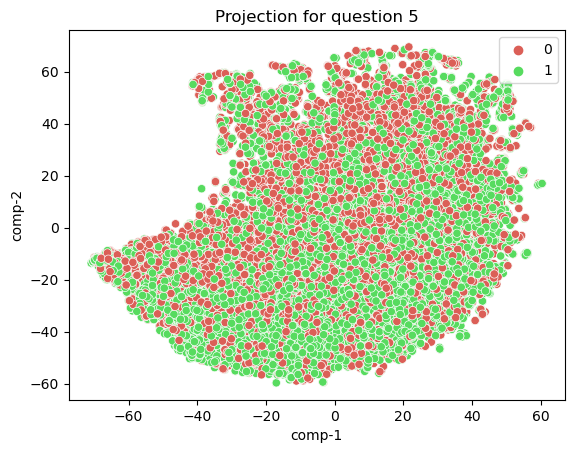

In [15]:
# Run a TSNE to see if the thing is classifiable
from sklearn.manifold import TSNE
import seaborn as sns

for t in range(5,6):
     # USE THIS TRAIN DATA WITH THESE QUESTIONS
    if t<=3: 
        grp = '0-4'
        df = df1
        FEATURES = FEATURES1
    elif t<=13: 
        grp = '5-12'
        df = df2
        FEATURES = FEATURES2
    elif t<=22: 
        grp = '13-22'
        df = df3
        FEATURES = FEATURES3

    target_y = targets.loc[targets.q==t].set_index('session').loc[ALL_USERS].correct

    tsne = TSNE(n_components=2, verbose=1, random_state=123)
    z = tsne.fit_transform(df[FEATURES].fillna(df[FEATURES].median()))

    df_tsne = pd.DataFrame()
    df_tsne["y"] = target_y
    df_tsne["comp-1"] = z[:,0]
    df_tsne["comp-2"] = z[:,1]

    tsne_plot = sns.scatterplot(x="comp-1", y="comp-2", hue=df_tsne.y.tolist(),
                palette=sns.color_palette("hls", 3),
                data=df_tsne).set(title=f"Projection for question {t}")
    
    fig = tsne_plot
    fig.savefig(f'Projection-for-question{t}.png')
